In [94]:

import numpy as np
import cv2
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import training_temp
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap


In [95]:
# Hyperparameters and settings
batch_size = 64
test_batch_size = 64
input_size = 1 # because there is only one channel 
output_size = 4
num_epochs = 10
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [96]:
# Load training, validation and training data

data_loader = torch.load('data_loader.pt')
valid_loader = torch.load('valid_loader.pt')
test_loader = torch.load('test_loader.pt')

# Move the data loaders to the desired device
data_loader.dataset.tensors = tuple(tensor.to(device) for tensor in data_loader.dataset.tensors)
valid_loader.dataset.tensors = tuple(tensor.to(device) for tensor in valid_loader.dataset.tensors)
test_loader.dataset.tensors = tuple(tensor.to(device) for tensor in test_loader.dataset.tensors)


In [97]:
# load model architectures from training_temp.py
model1 = training_temp.CNN()
model2 = training_temp.CNN2()
model3 = training_temp.CNN3()

model1.to(device)
model2.to(device)
model3.to(device)


CNN3(
  (conv_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=3136, out_features=1000, bias=True)
    (2): Re

In [98]:
#load the weights of the models
model1.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(8)/CNN.pth', map_location=device))
model2.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(8)/CNN2.pth', map_location=device))
model3.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(8)/CNN3.pth', map_location=device))

<All keys matched successfully>

In [99]:
# make confusion matrix based on test results
def confusion_matrix_data(model, test_loader):
    model.eval()
    predictions = []
    actual_labels = []
    f1_list = []
    recall_list = []
    precision_list = []
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
        # print(predictions)
        # print(actual_labels)

    return predictions, actual_labels

In [100]:
def calculate_model_performance_stats(model, test_loader):
    data_out = {}

    predictions, actual_labels = confusion_matrix_data(model, test_loader)

    data_out['name'] = model.name
    data_out['predictions'] = predictions
    data_out['actual_labels'] = actual_labels
    data_out['f1_macro'] = sklearn.metrics.f1_score(actual_labels, predictions, average='macro')
    data_out['f1_micro'] = sklearn.metrics.f1_score(actual_labels, predictions, average='micro')
    data_out['recall_macro'] = sklearn.metrics.recall_score(actual_labels, predictions, average='macro')
    data_out['recall_micro'] = sklearn.metrics.recall_score(actual_labels, predictions, average='micro')
    data_out['precision_macro'] = sklearn.metrics.precision_score(actual_labels, predictions, average='macro')
    data_out['precision_micro'] = sklearn.metrics.precision_score(actual_labels, predictions, average='micro')
    data_out['accuracy'] = sklearn.metrics.accuracy_score(actual_labels, predictions)
    
    cf_matrix = sklearn.metrics.confusion_matrix(actual_labels, predictions)
    classes = {'focused': 0, 'happy': 1, 'neutral': 2, 'surprised': 3}
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [key for key in classes],
                        columns = [key for key in classes])

    plt.figure(figsize = (12,7))
    #set labels

    # https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
    #add label to heatmap
    plt.title('Confusion Matrix for %s'%(model.name))
    
    #colour mapping for heatmap
    # colour_gradient = ["#E72A24", "#D2C631", "#31B329", "#00FFFF", "#0047AB"] # red, yellow, green, cyan, blue
    colour_gradient = ["#E72A24", "#FF8000" ,"#D2C631", "#31B329", "#00FFFF"] # red, yellow, green, cyan, blue
    # positions = [0.0, 0.10, 0.30, 0.50, 1.0]
    positions = [0.0, 0.10, 0.20, 0.60, 1.0] 
    custom_cmap = LinearSegmentedColormap.from_list("blue-to-red", list(zip(positions, colour_gradient)))
    
    sn.heatmap(df_cm, annot=True, cmap = custom_cmap).set(xlabel='Predicted Class', ylabel='Actual Class')
    plt.savefig('matrix_%s.png'%(model.name))
    return data_out

Macro precision for :  CNN 0.8917462604923605
Micro precision for :  CNN 0.8926666666666667
Macro recall for :  CNN 0.8926666666666666
Micro recall for :  CNN 0.8926666666666667
Macro F1 for :  CNN 0.8917599086004661
Micro F1 for :  CNN 0.8926666666666667
Accuracy for :  CNN 0.8926666666666667
__________________________________________________

Macro precision for :  CNN2 0.9078406348718139
Micro precision for :  CNN2 0.9006666666666666
Macro recall for :  CNN2 0.9006666666666666
Micro recall for :  CNN2 0.9006666666666666
Macro F1 for :  CNN2 0.9001424545737995
Micro F1 for :  CNN2 0.9006666666666666
Accuracy for :  CNN2 0.9006666666666666
__________________________________________________

Macro precision for :  CNN3 0.904123550692608
Micro precision for :  CNN3 0.9046666666666666
Macro recall for :  CNN3 0.9046666666666667
Micro recall for :  CNN3 0.9046666666666666
Macro F1 for :  CNN3 0.9041643563029431
Micro F1 for :  CNN3 0.9046666666666666
Accuracy for :  CNN3 0.904666666666666

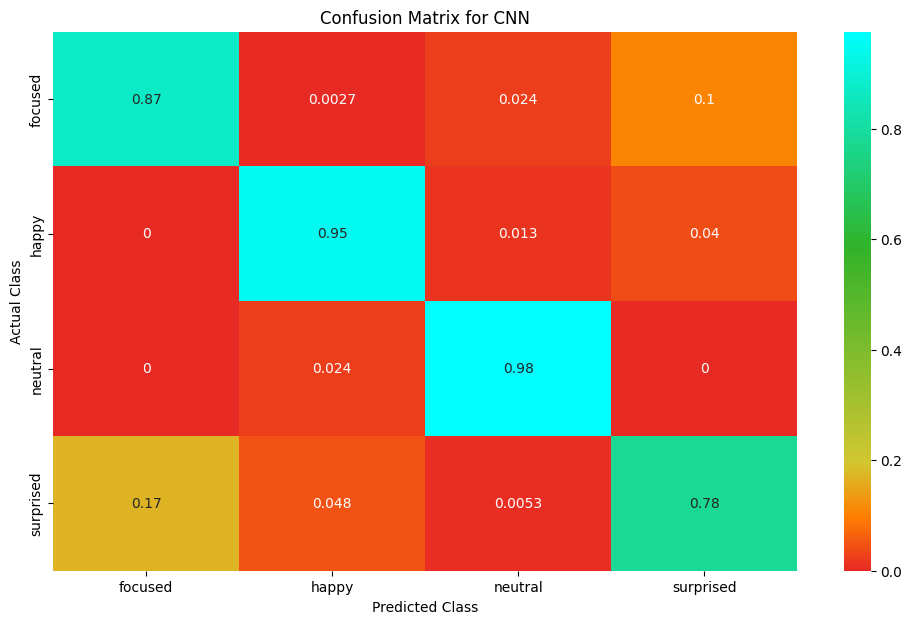

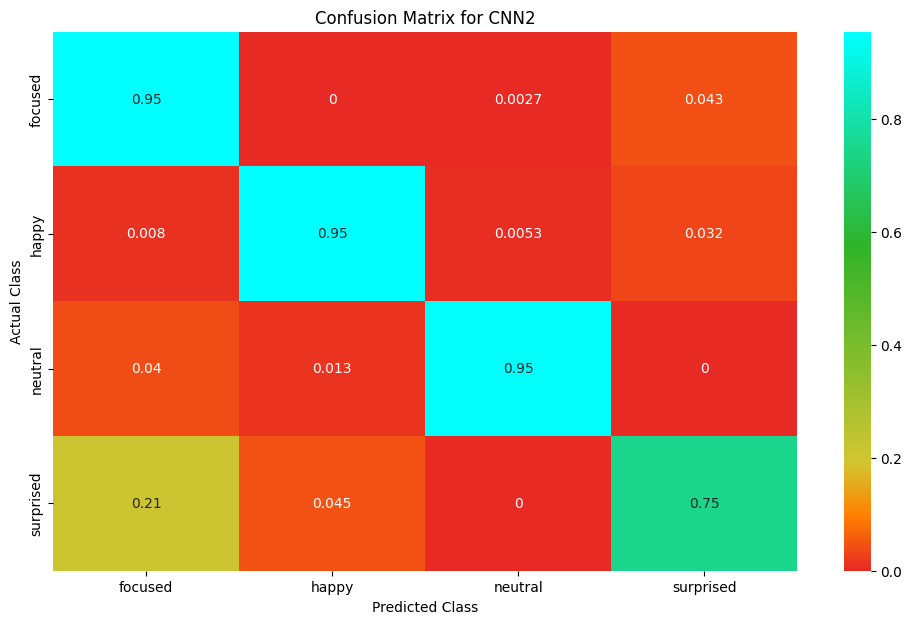

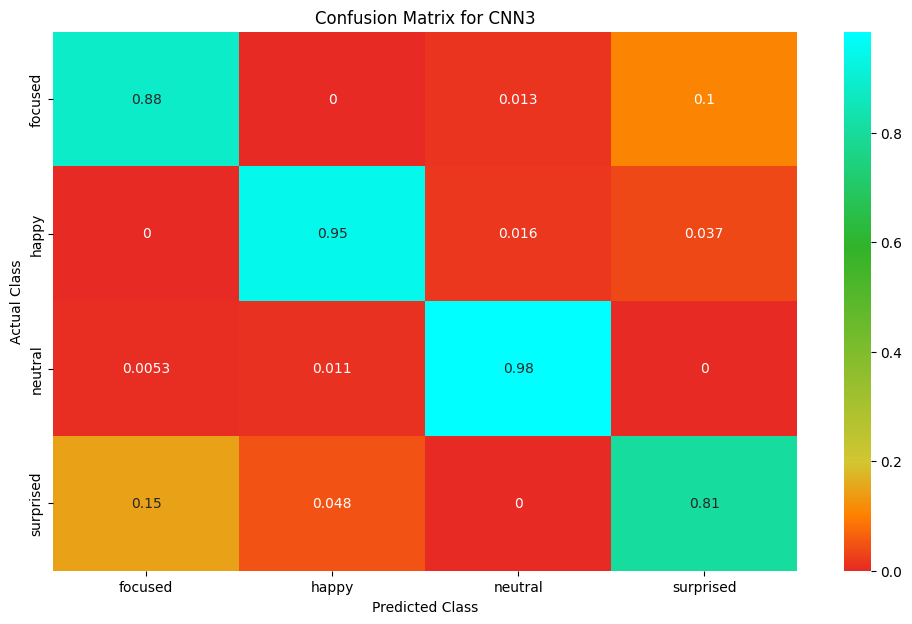

In [101]:
# printing the performance stats for each model
#NOTE: Average on micro would always be equal to accuracy since all classes have equal weights in the case of the project.
data_dicts = {'name': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'f1_micro': [], 'f1_macro': [], 'accuracy': []}
for model in [model1, model2, model3]:
    data_out = calculate_model_performance_stats(model, test_loader)
    print("Macro precision for : ", model.name, data_out['precision_macro'])
    print("Micro precision for : ", model.name, data_out['precision_micro'])
    print("Macro recall for : ", model.name, data_out['recall_macro'])
    print("Micro recall for : ", model.name, data_out['recall_micro'])
    print("Macro F1 for : ", model.name, data_out['f1_macro'])
    print("Micro F1 for : ", model.name, data_out['f1_micro'])
    print("Accuracy for : ", model.name, data_out['accuracy'])
    print("__________________________________________________\n")

    for key in data_dicts.keys():
        data_dicts[key].append(data_out[key])

In [102]:
#tabulating the CNN metrics using pandas
df = pd.DataFrame(data_dicts)

#set index to "name" column which is for CNN names
df = df.set_index('name', inplace=False)

#reorder columns
df = df[['precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro', 'accuracy']]


In [103]:
display(df)

,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accuracy
name,,,,,,,
CNN,0.891746,0.892667,0.891760,0.892667,0.892667,0.892667,0.892667
CNN2,0.907841,0.900667,0.900142,0.900667,0.900667,0.900667,0.900667
CNN3,0.904124,0.904667,0.904164,0.904667,0.904667,0.904667,0.904667


In [104]:
#saving the CNN metrics to a .csv file
df.to_csv("evaluation_stats.csv")